In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import splitfolders
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import splitfolders
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from skimage.io import imread
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [2]:

import shutil
import random

# Define the input and output paths
input_folder = r'C:\Users\LENOVO\Downloads\TB_Chest_Radiography_Database'
output_folder = r'C:\Users\LENOVO\Downloads\lung_data'


# Define the desired split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Create output folders for train, validation, and test sets
train_folder = os.path.join(output_folder, 'train')
val_folder = os.path.join(output_folder, 'val')
test_folder = os.path.join(output_folder, 'test')
os.makedirs(train_folder, exist_ok=True)
os.makedirs(val_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# Iterate through the classes (subfolders) in the input folder
for class_folder in os.listdir(input_folder):
    class_path = os.path.join(input_folder, class_folder)
    if os.path.isdir(class_path):
        # Create corresponding subfolders in the output folders
        train_class_path = os.path.join(train_folder, class_folder)
        val_class_path = os.path.join(val_folder, class_folder)
        test_class_path = os.path.join(test_folder, class_folder)
        os.makedirs(train_class_path, exist_ok=True)
        os.makedirs(val_class_path, exist_ok=True)
        os.makedirs(test_class_path, exist_ok=True)
        
        # List all images in the class folder
        images = os.listdir(class_path)
        # Shuffle the images to ensure randomness
        random.shuffle(images)
        
        # Calculate the number of images for each subset based on ratios
        num_images = len(images)
        num_train = int(train_ratio * num_images)
        num_val = int(val_ratio * num_images)
        num_test = num_images - num_train - num_val
        
        # Split images into train, validation, and test sets
        train_images = images[:num_train]
        val_images = images[num_train:num_train+num_val]
        test_images = images[num_train+num_val:]
        
        # Copy images to their respective folders
        for image in train_images:
            shutil.copy(os.path.join(class_path, image), os.path.join(train_class_path, image))
        for image in val_images:
            shutil.copy(os.path.join(class_path, image), os.path.join(val_class_path, image))
        for image in test_images:
            shutil.copy(os.path.join(class_path, image), os.path.join(test_class_path, image))


In [3]:
base_path = r"C:\Users\LENOVO\Downloads\lung_data" 

train_path = os.path.join(base_path, "train")
val_path = os.path.join(base_path, "val")
test_path = os.path.join(base_path, "test")

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
img_height = 320
img_width = 320
batch_size = 8
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   shear_range=0.2,  # Optional: Randomly shear images
                                   zoom_range=0.2,  # Optional: Randomly zoom images
                                   horizontal_flip=True)  # Optional: Randomly flip images horizontally

val_datagen = ImageDataGenerator(rescale=1./255) 

test_datagen = ImageDataGenerator(rescale=1./255)

# Define generators for training and validation data
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),  # Set your desired image size
    batch_size=batch_size,
    class_mode='binary'  # Assuming binary classification (nodule vs. no nodule)
)

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(img_height, img_width),
    class_mode='binary'  # Assuming same classes for testing
)

Found 3831 images belonging to 2 classes.
Found 1164 images belonging to 2 classes.
Found 1159 images belonging to 2 classes.


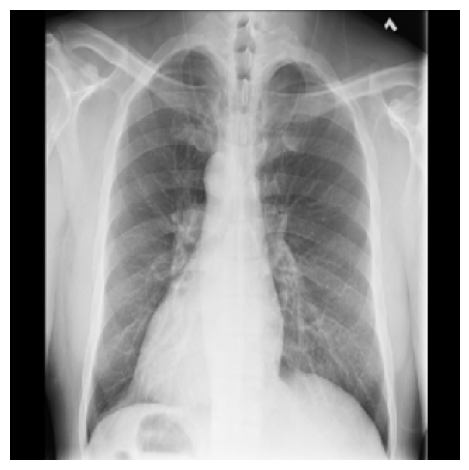

Image shape (320, 320, 3)


In [5]:
x, y = train_generator.__getitem__(0)
plt.imshow(x[0])
plt.axis("off")
plt.tight_layout()
plt.show()
print('Image shape',x[0].shape)

In [8]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping

base_model = DenseNet121(weights='imagenet', include_top=False, classes=2, input_shape=(320, 320, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)

output = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs = output)



In [10]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy", "AUC"])

history = model.fit(train_generator,
                              validation_data=val_generator,
                              steps_per_epoch=100,
                              validation_steps=30,
                              epochs=3,
                              callbacks=[EarlyStopping(monitor='val_loss', patience=2)])

Epoch 1/3


C:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 640s 4s/step - AUC: 0.8733 - accuracy: 0.8604 - loss: 0.3011 - val_AUC: 0.8187 - val_accuracy: 0.8750 - val_loss: 1.5858
Epoch 2/3
100/100 ━━━━━━━━━━━━━━━━━━━━ 352s 4s/step - AUC: 0.9560 - accuracy: 0.9473 - loss: 0.1767 - val_AUC: 0.5600 - val_accuracy: 0.1667 - val_loss: 4.9420
Epoch 3/3
100/100 ━━━━━━━━━━━━━━━━━━━━ 350s 4s/step - AUC: 0.9643 - accuracy: 0.9374 - loss: 0.1379 - val_AUC: 0.7428 - val_accuracy: 0.2542 - val_loss: 4.1798


In [43]:
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input

def load_and_preprocess_image(img_path, target_size=(320, 320)):
  # Load in grayscale if needed
  img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)  # Removed duplicate color_mode argument
  img_array = tf.keras.preprocessing.image.img_to_array(img)

  # Handle grayscale images appropriately
  if len(img_array.shape) == 3 and img_array.shape[-1] == 1:
    # Expand dimensions for grayscale images if DenseNet expects 3 channels
    img_array = tf.expand_dims(img_array, axis=-1)

  img_array = preprocess_input(img_array)  # Assuming DenseNet preprocessing
  img_array = tf.expand_dims(img_array, axis=0)  # Add batch dimension
  return img_array

In [48]:
import cv2
import numpy as np

def predict_with_saliency(model, img_path):
    # Load image
    original_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    original_img = cv2.resize(original_img, (224, 224))  # Resize to match model's expected sizing

    # Preprocess image
    input_img = np.expand_dims(original_img, axis=0)
    input_img = input_img / 255.0  # Normalize to [0,1]

    # Get model prediction probabilities
    prediction = model.predict(input_img)
    predicted_class = np.argmax(prediction)
    class_label = "Tuberculosis" if predicted_class == 1 else "Healthy"

    # Compute saliency map
    with tf.GradientTape() as tape:
        tape.watch(input_img)
        target = prediction[:, predicted_class]
    saliency_map = tape.gradient(target, input_img)[0]

    # Convert saliency map to heatmap (optional)
    saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())  # Normalize
    saliency_map = cv2.cvtColor(saliency_map, cv2.COLOR_GRAY2BGR)  # Convert to 3-channel image

    # Overlay saliency map with 50% transparency
    img_with_saliency = cv2.addWeighted(original_img, 0.5, saliency_map, 0.5, 0)

    return predicted_class, class_label, img_with_saliency

In [50]:
# Example usage
 img_path = r"C:\Users\LENOVO\Downloads\lung_data\train\Tuberculosis\Tuberculosis-575.png"
 predicted_class, class_label, output_image = predict_with_saliency(model, img_path)

 print(f"Predicted class: {predicted_class} ({class_label})")

 # Optionally save the image with saliency map
cv2.imwrite("output_with_saliency.jpg", output_image)